## Сверточная нейронная сеть для выявления трендов
Моделирование состоит из нескольких подзадач.
1. Необходимо научить сеть отличать тренды от флэтов (classification)
2. Необходимо научить сеть находить и распознавать объекты на большой картинке (detection)

На вход сверточной сети подаются матрицы, каждая из которых соответсвует одному окну разметки (то есть одному объекту). Сначала мы научим сеть классифицировать 3 вида состояний рынка (восходящий, нисходящий тренд и отсутсвие тренда), а потом будет учить распознавать их границы. Код ниже предназначен для решения первой задачи

In [1]:
#загрузка нужных библиотек (встроенные библиотеки Анаконды)
import pandas as pd
import numpy as np
import os
import time
#import datetime as dt
from __future__ import print_function
from __future__ import division
#from sklearn import linear_model
#from sklearn import ensemble, metrics 
#from sklearn import ensemble, cross_validation, learning_curve, metrics 
#from sklearn.externals import joblib
#from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV

In [2]:
import matplotlib
matplotlib.use('agg')#этот бэкэнд нужен чтобы переводить картинки сразу в RGB-матрицу
from matplotlib import pyplot as plt #Источник pip install mpl_finance - раньше было частью matplotlib
from mpl_finance import candlestick2_ohlc#модуль для рисования графиков со свечами

In [3]:
#библиотека для работы со сверточными сетями
import cntk as C #Источник: https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python
#для работы CNTK требуется доустановка MKL-DNN - https://anaconda.org/anaconda/mkl-dnn
#прогресс бар для контроля исполнения кода (актуально для длинных расчетов)
import progressbar as pbar# Источник: https://anaconda.org/conda-forge/progressbar2
import trend_functions as trd #может потребоваться установка xgboost - https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

In [4]:
import warnings;warnings.simplefilter('once')

## Подготовка исходных данных
После предыдущих этапов у нас уже имеются файлы с очищенными данными и проставленными метками - например, файл NewAllChangePoints_ln_121017v2BB.csv (способ получения такого файла описывается в коде trenddetection_alfa. Для работы кода требутся функции join_files,ChangePoints_preprocess (точнее- только UnknownToFlat,fill_trigger_by_idselect, add_direction,move_triggers)

Из этих данных нам нужны только стобцы с датами, ценой закрытия, идентификатором окна и меткой (восходящий и нисходящий тренд или отсутствие тренда)

In [5]:
#определяем источник данных
#path=os.path.join('C:/', 'Users', 'elzolotareva','Desktop','Alfa-Capital-VM')#виртуальная машина
path=os.path.abspath(os.curdir)#текущая папка
extention= "csv"#расширение, в котором сохранены файлы
# Определяем параметры для обучения модели
saveas="121017cnn_bb" 
# определяем, надо ли логарифмировать данные для обучения модели
logarithm=True
# если да, то прибавлем "_ln_" к метке saveas
ln="_ln_"if logarithm else ""
saveas=ln+saveas
mode="OUT" #для обучения моделей данные должны быть размеченными ("IN" - если нет)
#определяем параметры тестовой выборки
d_spl=""#по умолчанию
fraction =0.7#указывается пропорция, если мы делим выборку по дате
num_output_classes = 3 #метки принимают 3 возможных значения (1,-1 и 0)

In [ ]:
%%time
#загружаем данные (с логарифмами)
NewAllChangePoints=pd.read_csv(os.path.join(path, "NewAllChangePoints_ln_121017v2BB.csv"), header=0, sep=',',encoding='cp1251')

In [ ]:
#В сохраненном файле вместо значений  Open,High,Low находятся их отношения к цене закрытия (логарифмированной или нет)
#Чтобы восстановить исходные значения мы делаем обратное преобразование
#Этого можно избежать, если изначально работать с сырыми данными, а не с сохранненным файлом
num_cols=["Open_orig","High_orig","Low_orig","Close_orig", "Volume_orig"]
if logarithm: #для моделей, где использована разность логарифмов, а не частное
    NewAllChangePoints[num_cols]=np.exp(NewAllChangePoints[["Open","High","Low","Close","Volume"]])
else:    
    NewAllChangePoints[num_cols]=NewAllChangePoints["Open","High","Low","Close", "Volume"]
    
NewAllChangePoints["Open_orig"] =NewAllChangePoints["Open_orig"]*NewAllChangePoints["Close_orig"]
NewAllChangePoints["High_orig"] =NewAllChangePoints["High_orig"]*NewAllChangePoints["Close_orig"]
NewAllChangePoints["Low_orig"] =NewAllChangePoints["Low_orig"]*NewAllChangePoints["Close_orig"]

In [ ]:
#Отбираем только нужные колонки
CNN_Trends=NewAllChangePoints[["File_id","IDselect_tmp","Date","Open_orig","High_orig","Low_orig","Close_orig","NewTypeBool_sign"]]
if logarithm: #если далее надо вернуться к логарифмам
    CNN_Trends[["Open_orig","High_orig","Low_orig","Close_orig"]]= np.log(CNN_Trends[["Open_orig","High_orig","Low_orig","Close_orig"]])
CNN_Trends.to_csv(os.path.join(path,"CNN_Trends_" +ln+".csv"),sep = ',', index = False,header=1,encoding='cp1251')   

In [8]:
#Если такой файл уже сохранен, то можно его загрузить
CNN_Trends=pd.read_csv(os.path.join(path, "CNN_Trends_" +ln+".csv"), header=0, sep=',',encoding='cp1251')

In [9]:
# приводим дату к формату даты
CNN_Trends["Date"]=pd.to_datetime(CNN_Trends['Date'], format="%Y/%m/%d")
#Сортируем по номерам файлов, номеру окна и дате
CNN_Trends.sort_values(['File_id',"IDselect_tmp","Date"], ascending=True, inplace=True)

In [10]:
date_split,train_set,test_set,actual_fraction=trd.date_split(CNN_Trends,fraction)

2005-01-28 00:00:00 2017-09-13 00:00:00 2014-10-20 00:00:00


In [14]:
def CNN_trends_preprocess(input_set,ID_sel_col,dpi):
    """
    #Принимает на вход массив котировок (input_set), в колонке ID_sel_col указан номер окна,
    #dpi - разрешение, с которым сохраняются картинки
    #Возвращает CNN_data - массив из оцифрованных картинок с метками
    #CNN_images - только оцифрованные картинки,CNN_labels - только метки,
    #CNN_shape - размер одной картинки в формате "высота,ширина, количество каналов"
    """
    CNN_data={}
    CNN_images={}
    CNN_labels={}
    allfiles=list(input_set["File_id"].drop_duplicates())
    bar = pbar.ProgressBar(max_value=len(allfiles)).start() # Создаём новый progress bar
    t=0
    n=0
    for f in allfiles:# перебираем все файлы
        TrendNew=input_set[input_set["File_id"]==f]
        irange=list(TrendNew[ID_sel_col].drop_duplicates())#составляем список окон разметки
        for i in irange:#для каждого окна
            TaggedWin=TrendNew[TrendNew [ID_sel_col]==i]
            fig, ax = plt.subplots(dpi=dpi)#(figsize=(1,1))
            #fig.figsize=(28, 28)
            plt.axis('off')
            fig.tight_layout(pad=0)
            #fig.dpi=100
            candlestick2_ohlc(ax,TaggedWin["Open_orig"],TaggedWin["High_orig"],TaggedWin["Low_orig"],TaggedWin["Close_orig"],
                              colorup='b', colordown='r',width=1,alpha=1)#Цвета такие, чтобы в RGB было больше нулей
            #fig.canvas.
            #fig.dpi=100
            fig.canvas.draw()#отрисовываем картинку
            #print(fig.canvas.get_width_height())
            #fig.figsize=(28, 28)
            image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)#получаем из картинки матрицу RGB в виде вектора
            CNN_data[(f,i)]=np.hstack((image_flat,int(np.mean(TaggedWin["NewTypeBool_sign"]))))#матрица RGB в виде вектора+label
            
            #CNN_images_flat[(f,i)]=image_flat#сохраняем в словарь
            image = image_flat.reshape(fig.canvas.get_width_height()[::-1] + (3,))#превращаем в массив размером (height,width,3)
            CNN_images[(f,i)]=image#сохраняем в словарь
            CNN_labels[(f,i)]=int(np.mean(TaggedWin["NewTypeBool_sign"]))
#             plt.savefig(os.path.join(path,"trend_images_"+str(dpi)+"dpi", f+ln+"_"+str(int(i))+"_"+str(int(CNN_labels[(f,i)]))+'.png'), 
#                         dpi=dpi,bbox_inches='tight',pad_inches=0,transparent=True)
            CNN_shape=fig.canvas.get_width_height()[::-1] + (3,) #кортеж: высота,ширина, количество каналов
            plt.close(fig)
        t+=1
        bar.update(t)
    bar.finish()
    return CNN_data,CNN_images,CNN_labels,CNN_shape

In [15]:
matplotlib.pyplot.close('all')

In [16]:
dpi=10
#CNN_train,CNN_im_train,CNN_lab_train,CNN_shape_train=CNN_trends_preprocess(train_set.head(50000),"IDselect_tmp",dpi)
#CNN_test,CNN_im_test,CNN_lab_test,CNN_shape_test=CNN_trends_preprocess(test_set.head(2500),"IDselect_tmp",dpi)
CNN_train,CNN_im_train,CNN_lab_train,CNN_shape_train=CNN_trends_preprocess(train_set,"IDselect_tmp",dpi)
CNN_test,CNN_im_test,CNN_lab_test,CNN_shape_test=CNN_trends_preprocess(test_set,"IDselect_tmp",dpi)

100% (1341 of 1341) |#####################| Elapsed Time: 0:21:19 Time: 0:21:19
100% (1389 of 1389) |#####################| Elapsed Time: 0:10:36 Time: 0:10:36


In [17]:
train_size =np.array(list(CNN_train.values())).shape[0]
test_size =np.array(list(CNN_test.values())).shape[0]
if CNN_shape_train==CNN_shape_test: 
    CNN_shape = CNN_shape_train
else:raise Exception("Train and test have different shapes") 
print(np.array(list(CNN_train.values())).shape)
print(np.array(list(CNN_test.values())).shape)
print(CNN_shape)

(10258, 9217)
(5547, 9217)
(48, 64, 3)


In [18]:
def transpose_data(input_dic, output_dic):
    """
   
    #Получает на вход два словаря  с инпутами  и аутпутами, соответсвующими одинаковым ключам
    #В словарях для каждого ключа сохранена матрицам определенных размеров
    #В этих матрицах надо инвертировать порядок измерений (для соответсвия требованиям СNTK), 
    # а потом уплощить и сохранить в новый словарь
    """ 
    
    data_trans_flat={}
    for key in input_dic:
        input_trans_flat=np.transpose(input_dic[key]).flatten()
        output_trans_flat=np.transpose(output_dic[key]).flatten()
        data_trans_flat[key]=np.hstack((input_trans_flat,output_trans_flat))
    return data_trans_flat

In [19]:
# Save the data files into a format compatible with CNTK text reader (формат CTF)
# Источник - Майкрософт +модификации
def savetxt(filename, ndarray, num_output_classes, norm=False):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(num_output_classes, dtype=np.uint).astype(str)))#преобразование в  one-hot-encoding
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]#последний элемент в строке (метка), преобразованный в one-hot-encoding
                if norm: 
                    feature_str= ' '.join((row[:-1]/255).astype(str))#все: кроме последнего с разделителем " "
                else:feature_str = ' '.join(row_str[:-1])#все: кроме последнего с разделителем " "      
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)

In [20]:
norm=True
norm_str="_norm" if norm else ""
train_file_name="Train_trans"+str(dpi)+"dpi_"+str(train_size)+norm_str+".txt"
test_file_name="Test_trans"+str(dpi)+"dpi_"+str(test_size)+norm_str+".txt"
CNN_train_trans=transpose_data(CNN_im_train,CNN_lab_train)
CNN_test_trans=transpose_data(CNN_im_test,CNN_lab_test)
savetxt(os.path.join(path, train_file_name), np.array(list(CNN_train_trans.values())),num_output_classes,norm)
savetxt(os.path.join(path, test_file_name), np.array(list(CNN_test_trans.values())), num_output_classes,norm)

Saving C:\Users\elzolotareva\Desktop\Alfa-Capital-VM\Train_trans10dpi_10258_norm.txt
Saving C:\Users\elzolotareva\Desktop\Alfa-Capital-VM\Test_trans10dpi_5547_norm.txt


## Загрузка данных в нужном формате

In [21]:
use_current=True
if not use_current:    
    num_output_classes = 3
    #dpi=60
    dpi=20
    CNN_shape=(int(dpi/10*48),int(dpi/10*64),3)
    #CNN_shape=(96, 128, 3)# 20 dpi
    #CNN_shape=(288,384,3)# 60 dpi
    norm=True
    #В идеале размер выборки надо определять по файлу, но тогда его придется загрузить сначала
    train_size=10258
    test_size=5547
    #train_size=234 
    #test_size=136
    
    norm_str="_norm" if norm else ""
    train_file_name="Train_trans"+str(dpi)+"dpi_"+str(train_size)+norm_str+".txt"
    test_file_name="Test_trans"+str(dpi)+"dpi_"+str(test_size)+norm_str+".txt"

In [22]:
# Ensure the training and test data is available
data_found=False # A flag to indicate if train/test data found in local cache
train_file=os.path.join(path, train_file_name)
test_file=os.path.join(path, test_file_name)  
if os.path.isfile(train_file) and os.path.isfile(test_file): data_found=True
if not data_found:
    raise ValueError("Data not found")

In [23]:
# Фиксируем параметры, отвечающие за "случайность" для возможности воспроизведения результата
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Определяем размерность данных
input_dim_model = CNN_shape [::-1]  # images are 384 (image width) x 288 (image height) with 3 channel of color (RGB) 
input_dim = int(np.prod(CNN_shape)) # used by readers to treat input data as a vector??? (перемножаем первые 2 измерения - высоту и длину)


In [24]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

## Создание модели

In [25]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


In [27]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(25,25), 
                                       num_filters=8, 
                                       strides=(5,5), 
                                       pad=True, name='first_conv')(h)
#             h=C.layers.AveragePooling(filter_shape=(40,40), 
#                                       strides=(1,1),name="first_pool")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                      pad=True, name='second_conv')(h)
#             h=C.layers.AveragePooling(filter_shape=(20,20), 
#                                       strides=(2,2),name="second_pool")(h)
#             h = C.layers.Convolution2D(filter_shape=(8,8), 
#                                        num_filters=32, 
#                                        strides=(2,2), 
#                                        pad=True, name='third_conv')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

In [28]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
# print("Output Shape of the first pooling layer:", z.first_pool.shape)
print("Output Shape of the second convolution layer:", z.second_conv.shape)
# print("Output Shape of the first pooling layer:", z.second_pool.shape)
#print("Output Shape of the third convolution layer:", z.third_conv.shape)

print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 13, 10)
Output Shape of the second convolution layer: (16, 7, 5)
Bias value of the last dense layer: [0. 0. 0.]


C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


In [29]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 19907 parameters in 6 parameter tensors.


## Обучение модели

In [30]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

In [31]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
# def moving_average(a, w=5):
#     if len(a) < w:
#         return a[:]    # Need to send a copy of the array
#     return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [32]:
def train_test(train_reader, test_reader, model_func, test_size, train_size, learning_rate=0.001, norm=False,num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func if norm else model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    #learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = min(64, train_size)
    num_samples_per_sweep = train_size
    num_minibatches_to_train =(num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size =min(512, test_size)
    num_samples =test_size
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a trend image of 288*384*3 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

In [33]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    learning_rate = 0.001
    num_sweeps_to_train_with=100
    train_test(reader_train, reader_test, z,test_size, train_size, learning_rate,norm,num_sweeps_to_train_with)
    
do_train_test()

C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


Minibatch: 0, Loss: 1.2457, Error: 75.00%
Minibatch: 500, Loss: 0.6171, Error: 21.88%
Minibatch: 1000, Loss: 0.7733, Error: 31.25%
Minibatch: 1500, Loss: 0.4154, Error: 17.19%
Minibatch: 2000, Loss: 0.3261, Error: 14.06%
Minibatch: 2500, Loss: 0.3749, Error: 12.50%
Minibatch: 3000, Loss: 0.2562, Error: 6.25%
Minibatch: 3500, Loss: 0.3150, Error: 10.94%
Minibatch: 4000, Loss: 0.3934, Error: 18.75%
Minibatch: 4500, Loss: 0.4587, Error: 18.75%
Minibatch: 5000, Loss: 0.3357, Error: 18.75%
Minibatch: 5500, Loss: 0.1869, Error: 4.69%
Minibatch: 6000, Loss: 0.2124, Error: 9.38%
Minibatch: 6500, Loss: 0.4823, Error: 20.31%
Minibatch: 7000, Loss: 0.2953, Error: 10.94%
Minibatch: 7500, Loss: 0.2746, Error: 7.81%
Minibatch: 8000, Loss: 0.2582, Error: 9.38%
Minibatch: 8500, Loss: 0.1777, Error: 6.25%
Minibatch: 9000, Loss: 0.1503, Error: 4.69%
Minibatch: 9500, Loss: 0.3286, Error: 12.50%
Minibatch: 10000, Loss: 0.3441, Error: 17.19%
Minibatch: 10500, Loss: 0.2395, Error: 7.81%
Minibatch: 11000, Lo

In [93]:
print("Bias value  of the last dense layer:", z.classify.b.value)

Bias value  of the last dense layer: [ 0.00737745 -0.00337819 -0.00399925]


## Предсказания

In [34]:
out = C.softmax(z)

In [35]:
out.save(os.path.join(path, "CNN_19_trans.model"))

In [36]:
#out = C.Function.load(os.path.join(path, "CNN_16_3.model"))

In [37]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size =test_size#M
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

trd_label = data[y].asarray()
trd_data = data[x].asarray()

# reshape trd_data to: M x 3 (channel of color)x384 (image width) x 288 (image height)  to be compatible with model
trd_data = np.reshape(trd_data, tuple(np.hstack((eval_minibatch_size,input_dim_model))))
predicted_label_prob = [out.eval(trd_data[i]) for i in range(len(trd_data))]

In [38]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(trd_label[i]) for i in range(len(trd_label))]

In [39]:
print ("Стурктура predictions", pd.Series(pred).value_counts())

Стурктура predictions 0    3116
1    1811
2     620
dtype: int64


In [40]:
print("Стурктура ground truth", pd.Series(gtlabel).value_counts())

Стурктура ground truth 0    3235
1    1642
2     670
dtype: int64


In [41]:
print("Label    :", gtlabel[:np.min([eval_minibatch_size,25])])
print("Predicted:", pred[:np.min([eval_minibatch_size,25])])

Label    : [0, 2, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0]
Predicted: [1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0]


In [42]:
errors=pd.Series(pd.Series(gtlabel)!=pd.Series(pred))
trd_errors=trd_data[errors]
pred_errors=np.array(pred)[errors]
gtlabel_errors=np.array(gtlabel)[errors]
print ("Количество ошибок", trd_errors.shape[0])

Количество ошибок 625


In [43]:
if not norm: trd_data=trd_data/255

In [44]:
#trd_data=trd_data*255

Predicted Label:  0   Ground truth : 2


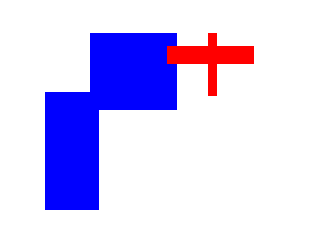

In [45]:
# Визуализация
# Берем случайное изображение
sample_number = 17
%matplotlib inline

plt.imshow(np.transpose(trd_data[sample_number].reshape(input_dim_model)))#, cmap="gray_r")
plt.axis('off')

trd_gt, trd_pred = gtlabel[sample_number], pred[sample_number]
print("Predicted Label: ", trd_pred, "  Ground truth :",trd_gt )

Predicted Label:  0   Ground truth : 2


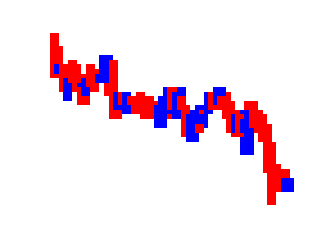

In [47]:
#Визуализация ошибокv-не такие уж они и страшные ошибки, а вполне логичные
# Берем случайное изображение
error_number = 5
%matplotlib inline

plt.imshow(np.transpose(trd_errors[error_number].reshape(input_dim_model)))#, cmap="gray_r")
plt.axis('off')

trd_gt, trd_pred = gtlabel_errors[error_number], pred_errors[error_number]
print("Predicted Label: ", trd_pred, "  Ground truth :",trd_gt )

In [62]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(gtlabel, pred)
cnf_matrix

array([[2865,  247,  123],
       [  82, 1560,    0],
       [ 169,    4,  497]], dtype=int64)

In [57]:

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[2865  247  123]
 [  82 1560    0]
 [ 169    4  497]]
Normalized confusion matrix
[[0.89 0.08 0.04]
 [0.05 0.95 0.  ]
 [0.25 0.01 0.74]]


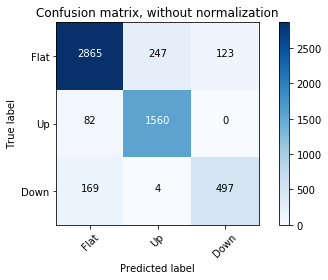

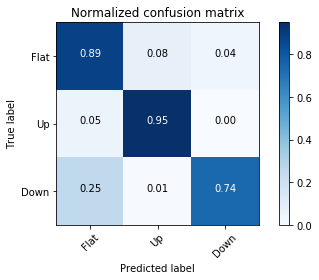

In [63]:
%matplotlib inline
# Compute confusion matrix
class_names=["Flat", "Up", "Down"]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()